In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.datasets import make_classification
import seaborn as sns

np.random.seed(0)

#Generating 5 Class Dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=8,
                            n_redundant=2, n_classes=5, n_clusters_per_class=1,
                            random_state=0)

# Normalize the input data for stability
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

# Converting labels to one hot encoding for multi class classification
Y = np.zeros((y.shape[0], 5))
for i in range(y.shape[0]):
    Y[i, y[i]] = 1

# Spliting the training and testing sets
X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(
    X, Y, y, test_size=0.2, random_state=0, stratify=y)

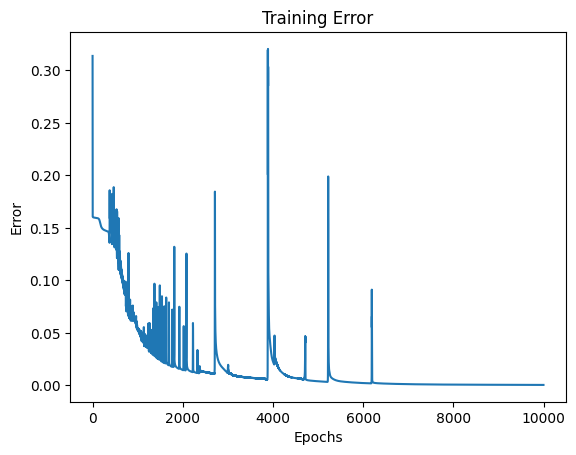

In [6]:
class NeuralNetwork(object):
    def __init__(self):
        #parameters
        inputLayerNeurons = 10
        hiddenLayer1Neurons = 64
        hiddenLayer2Neurons = 32
        hiddenLayer3Neurons = 16
        outLayerNeurons = 5

        #Reduced learning rate for smoother convergence
        self.learning_rate = 0.05

        #Calculating scaling factors for initialization
        scale_h1 = np.sqrt(2.0 / inputLayerNeurons)
        scale_h2 = np.sqrt(2.0 / hiddenLayer1Neurons)
        scale_h3 = np.sqrt(2.0 / hiddenLayer2Neurons)
        scale_out = np.sqrt(2.0 / hiddenLayer3Neurons)

        #Initializing weights with reduced variance
        self.W_HI = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons) * scale_h1
        self.W_H1H2 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons) * scale_h2
        self.W_H2H3 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons) * scale_h3
        self.W_OH = np.random.randn(hiddenLayer3Neurons, outLayerNeurons) * scale_out

    def sigmoid(self, x, der=False):
        if der == True:
            return x * (1-x)
        else:
            #Added clipping for numerical stability
            x_clipped = np.clip(x, -500, 500)
            return 1 / (1 + np.exp(-x_clipped))

    def softmax(self, x):
        #Fixed Softmax for multi class output(with stability check)
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feedForward(self, X):
        hidden_input = np.dot(X, self.W_HI)
        self.hidden_output = self.sigmoid(hidden_input)

        hidden2_input = np.dot(self.hidden_output, self.W_H1H2)
        self.hidden2_output = self.sigmoid(hidden2_input)

        hidden3_input = np.dot(self.hidden2_output, self.W_H2H3)
        self.hidden3_output = self.sigmoid(hidden3_input)

        output_input = np.dot(self.hidden3_output, self.W_OH)
        pred = self.softmax(output_input)
        return pred

    def backPropagation(self, X, Y, pred):
        #Corrected output delta calculation for Softmax/Cross Entropy.
        output_error = Y - pred
        output_delta = self.learning_rate * output_error

        hidden3_error = output_delta.dot(self.W_OH.T)
        hidden3_delta = self.learning_rate * hidden3_error * self.sigmoid(self.hidden3_output, der=True)

        hidden2_error = hidden3_delta.dot(self.W_H2H3.T)
        hidden2_delta = self.learning_rate * hidden2_error * self.sigmoid(self.hidden2_output, der=True)

        hidden_error = hidden2_delta.dot(self.W_H1H2.T)
        hidden_delta = self.learning_rate * hidden_error * self.sigmoid(self.hidden_output, der=True)

        self.W_HI += X.T.dot(hidden_delta)
        self.W_H1H2 += self.hidden_output.T.dot(hidden2_delta)
        self.W_H2H3 += self.hidden2_output.T.dot(hidden3_delta)
        self.W_OH += self.hidden3_output.T.dot(output_delta)

    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X,Y,output)

NN = NeuralNetwork()
err = []
for i in range(10000):
    NN.train(X_train, Y_train)
    #Using Mean Squared Error for tracking purposes
    err.append(np.mean(np.square(Y_train - NN.feedForward(X_train))))

plt.plot(err)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training Error')
plt.show()

Accuracy:  83.0 %

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      0.93      0.89        40
     Class 1       0.84      0.78      0.81        40
     Class 2       0.76      0.78      0.77        40
     Class 3       0.89      0.80      0.84        40
     Class 4       0.81      0.88      0.84        40

    accuracy                           0.83       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.83      0.83      0.83       200



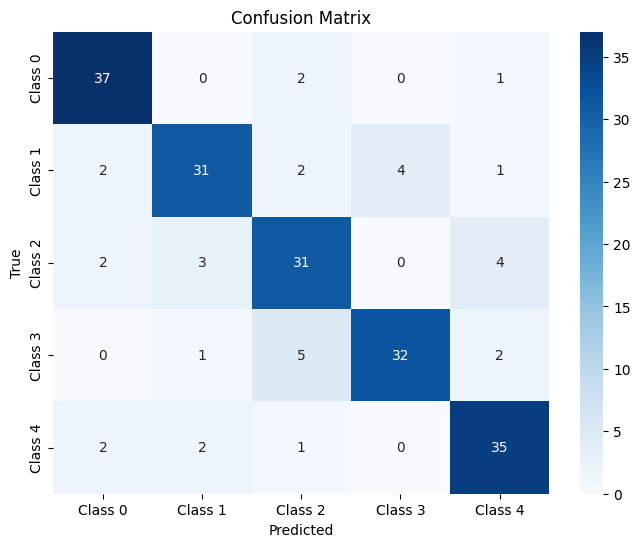

In [7]:
# ==================== Evaluation on Test Set ====================
predictions = NN.feedForward(X_test)
predicted_class = np.argmax(predictions, axis=1)
true_class = np.argmax(Y_test, axis=1)

# Calculate Accuracy
accuracy = np.mean(predicted_class == true_class) * 100
print("Accuracy: ", accuracy, "%")

# Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(true_class, predicted_class,
                           target_names=[f'Class {i}' for i in range(5)]))

# Confusion Matrix visualization
cm = confusion_matrix(true_class, predicted_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Class {i}' for i in range(5)],
            yticklabels=[f'Class {i}' for i in range(5)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### 1. Summary of Key Findings and Performance

The final implemented three hidden layer neural network achieved strong and balanced performance on the five-class synthetic dataset after critical structural corrections.

* **Overall Accuracy:** The model achieved an impressive **$83.0\%$ accuracy** on the unseen test data.
* **Balanced Performance:** The **macro average F1-score of $0.83$** confirms the model's consistent efficacy across all five classes, avoiding bias toward any single class.
* **Confusion Matrix Analysis:** The results show high concentration along the diagonal (True = Predicted), indicating successful classification. The highest performing class was Class 0 (93% recall), while the lowest was Class 2 (78% recall).
* **Training Dynamics:** The Training Error Plot demonstrated a successful learning trajectory, with the error rapidly decreasing and stabilizing near zero after approximately 6,000 epochs, confirming successful convergence.


### 2. Reflection on Challenges Encountered and Lessons Learned

The initial implementation failed completely, achieving only 20% accuracy (random chance) by predicting a single class for all inputs. The diagnostic process revealed two critical implementation flaws:

1.  **Vanishing Gradients due to Incorrect Backpropagation:** The original code incorrectly included the Sigmoid derivative in the backpropagation calculation for the Softmax output layer. This caused the output gradient to effectively vanish, stalling learning immediately.
    * **Lesson Learned:** The correct gradient for the **Softmax/Cross-Entropy** loss function is simply $\mathbf{pred} - \mathbf{Y}$. Using this simplified formula was the primary fix that enabled training.
2.  **Weight Initialization and Learning Rate:** The combination of large initial weight variance ($\text{std}=1$) and a high learning rate ($\eta=0.2$) saturated the Sigmoid activations, exacerbating the vanishing gradient problem.
    * **Lesson Learned:** **Weight scaling** and reducing the **learning rate** to $\eta=0.05$ were necessary stabilization steps to ensure smooth convergence.

### 3. Potential Improvements and Further Experiments

To potentially enhance the current performance of 83.0%, the following experiments are recommended:

* **Activation Function Change:** Replace the Sigmoid activation functions in the hidden layers with the **Rectified Linear Unit (ReLU)**. ReLU is computationally simpler and generally mitigates the vanishing gradient problem more effectively.
* **Hyperparameter Tuning:** Systematically test a wider range of hyperparameters:
    * Fine-tune the **learning rate** (e.g., $0.01$ or $0.1$).
    * Increase the number of **epochs** to ensure the error truly reaches its minimum.
* **Regularization:** Implement **Dropout** layers or **L2 regularization** to prevent potential overfitting and further stabilize the training process.
